In [106]:
import os
import time
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from skimage.feature import hog
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from IPython.display import HTML

ImportError: No module named 'imageio'

Reading 17760 images
******************Done extracting features
13320 training images and 6156 features
Fit in 16.20 s
Test acc 0.987


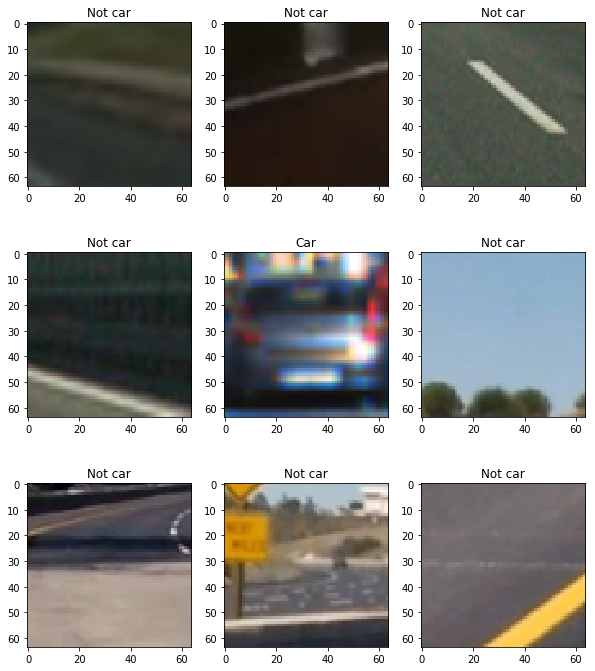

In [15]:
classifier, scaler = train_car_classifier('./data/vehicles/', 
                                          './data/non-vehicles/',
                                          display=True)

## Classifier
* Linear SVC classifier used
* HSV color space used
* Spatial binning of color used with a size of 16x16
* Histogram of colors used with 32 bins
* Histogram of gradients used
    * 8 pixels per cell and 2 cells per block
    * Number of orientation bins set to 9 based on this [paper](https://courses.engr.illinois.edu/ece420/fa2017/hog_for_human_detection.pdf) which showed statistically significant increases in performance up to 9 bins.

In [ ]:
classifier, scaler = train_car_classifier('./data/vehicles/', 
                                          './data/non-vehicles/')

In [3]:
#------------------80-chars----------------------------------------------------|
def train_car_classifier(veh_path, nonveh_path, display=False):
    """
    Trains a classifier to recognize cars
    
    :param veh_path: Directory where vehicles images are found
    :param nonveh_path: Directory where non-vehicle images are found
    :param display: Whether to display information about progress and tests set
    :return classifier: A classifier that detects cars
    :return X_scaler: Scaler used to remove mean and scaling of features
    """
    veh_files = retrieve_files(veh_path, 'png')
    nonveh_files = retrieve_files(nonveh_path, 'png')
    img_files = np.hstack((veh_files, nonveh_files))
    labels = np.hstack((np.ones(veh_files.shape[0]), 
                        np.zeros(nonveh_files.shape[0])))
    features = []
    if display:
        print('Reading {0} images'.format(len(img_files)))
    for count, img_file in enumerate(img_files):
        if count % 1000 == 0:
            if display:
                print('*', end='')
        img = mpimg.imread(img_file)
        if img.dtype == np.dtype(np.float32):
            img = np.uint8(img*255)
        features.append(get_classifier_features(img, color_space='HSV'))
    if display:
        print('Done extracting features')
    X = np.asarray(features)
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
        X_scaled, labels, img_files)
    
    classifier = LinearSVC()
    t_i = time.time()
    classifier.fit(X_train, y_train)
    t_f = time.time()
    if display:
        print('{0} training images and {1} features'.format(X_train.shape[0],
                                                            X_train.shape[1]))
        print('Fit in {0:.2f} s'.format(t_f - t_i))
        print('Test acc {0:.3f}'.format(classifier.score(X_test, y_test)))
        for i in range(1, 10):
            test_img = mpimg.imread(img_test[i])
            ax = plt.subplot(3,3,i)
            prediction = classifier.predict(X_test[i].reshape(1, -1))
            if prediction == 1:
                ax.set_title('Car')
            else:
                ax.set_title('Not car')
            ax.imshow(test_img)
        plt.show()
    return classifier, X_scaler

In [4]:
#------------------80-chars----------------------------------------------------|
def retrieve_files(file_folder, file_format):
    """
    Returns an array of all image *files* in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([file for file in image_files])

In [5]:
#------------------80-chars----------------------------------------------------|
def get_classifier_features(img, hist_bool=True, spatial_bool=True, 
                            hog_bool=True, color_space='RGB', hog_channel=3, 
                            pix_per_cell=8, cells_per_block=2, orient=9):
    """
    Combine different feature vectors together for each image
    
    :param img: Image to extract features from
    :param hist_bool: Whether or not to include histogram of color features
    :param spatial_bool: Whether or not to include spatial color features
    :param hog_bool: Whether or not to include histogram of gradient features
    :param color_space: Color space to convert features to before extracting
    :param hog_channel: Channel to include in HOG features. 0-1st, 3-all
    :param pix_per_cell: Pixels per hog cell
    :param cells_per_block: Cells ber hog block
    :param orient: Direction bins in histogram for HOG
    :return features: HOG feature vector
    """
    features = []
    height, width, _ = img.shape
    hist_feat = []
    spatial_feat = []
    hog_feat = []
    img = convert_color(img, cspace=color_space)
    #TODO: Loop over image
    if hist_bool:
        hist_feat = color_hist(img)
    if spatial_bool:
        spatial_feat = bin_spatial(img)
    if hog_bool:
        hog_feat = get_hog_features(img, hog_channel, pix_per_cell, 
                                    cells_per_block, orient)
#     print(hist_feat.shape, spatial_feat.shape, hog_feat.shape)
    features = np.hstack((hist_feat, spatial_feat, hog_feat))
    return features

In [6]:
def convert_color(img, cspace='RGB'):
    """
    Converts an RGB image to the given color space
    Available - RGB, BGR, HSV, HLS, YUV, YCC, LUV, LAB
    
    :param img: Image to convert
    :param cspace: Colorspace to convert image to
    """
    
    if cspace == 'RGB':
        return img
    if cspace == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if cspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if cspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if cspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if cspace == 'YCC':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    if cspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if cspace == 'LAB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

In [7]:
def bin_spatial(img, size=(16,16)):
    """
    Create feature to represent position of color in space
    
    :param img: Image to extract feature from
    :param size: Size at which to extract features
    """
    ch_0 = cv2.resize(img[:,:,0], size).ravel()
    ch_1 = cv2.resize(img[:,:,1], size).ravel()
    ch_2 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((ch_0, ch_1, ch_2))

In [8]:
#------------------80-chars----------------------------------------------------|
def color_hist(img, n_bins=32):
    """
    Create feature vector of an images distribution of colors with histograms
    
    :param img: Image to extract color features from
    :param n_bins: Number of bins to sort pixel intensities into
    """
    
    ch_0_hist = np.histogram(img[:,:,0], bins=n_bins)[0]
    ch_1_hist = np.histogram(img[:,:,1], bins=n_bins)[0]
    ch_2_hist = np.histogram(img[:,:,2], bins=n_bins)[0]
    return np.hstack((ch_0_hist, ch_1_hist, ch_2_hist))

In [9]:
def get_hog_features(img, channel, pix_per_cell, cells_per_block, orient):
    """
    Extract histogram of gradient features from an image
    
    :param img: Image to extract features from
    :param channel: Channel to include 0-1st, 1-2nd, 2-3rd, 3-all
    :param pix_per_cell: Pixels per hog cell
    :param cells_per_block: Cells ber hog block
    :param orient: Direction bins in histogram for HOG
    :return hog_feat: HOG feature vector
    """
    hog_feat = []
    if channel == 0 or channel == 3:
        hog_0 = hog(img[:,:,0], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cells_per_block, cells_per_block),
                    feature_vector=False, block_norm='L2-Hys')
        hog_feat.append(np.ravel(hog_0))
    if channel == 1 or channel == 3:
        hog_1 = hog(img[:,:,1], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cells_per_block, cells_per_block),
                    feature_vector=False, block_norm='L2-Hys')
        hog_feat.append(np.ravel(hog_1))
    if channel == 2 or channel == 3:
        hog_2 = hog(img[:,:,2], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cells_per_block, cells_per_block),
                    feature_vector=False, block_norm='L2-Hys')
#         print(hog_2.shape)
        hog_feat.append(np.ravel(hog_2))
    hog_feat = np.hstack(hog_feat)
    return hog_feat
        

In [99]:
#------------------80-chars----------------------------------------------------|
def pipeline(img, display=False):
    """
    Pipeline detects vehicles in an image
    Uses global classifier to prevent passing large data a lot
    
    :param img: Image to detect cars in
    :return final_img: Image with bounding boxes around cars
    """
    top_img, img = split_image(img, 0.5)
    small_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.8, overlap=0.5)
    med_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.6, overlap=0.6)
    large_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.4)
    boxes = np.concatenate((small_boxes, med_boxes, large_boxes))
    if display:
        box_img = np.copy(img)
        for bounding_box in boxes:
            cv2.rectangle(box_img, (bounding_box[2], bounding_box[0]),
                                   (bounding_box[3], bounding_box[1]),
                                   (255, 0, 0), 6)
        plt.imshow(box_img)
        plt.show()
    detection_heatmap = add_heat(img, boxes)
    detection_heatmap = apply_threshold(detection_heatmap, 2)
    labels = label_cars(detection_heatmap, display=display)
    img = draw_labeled_boxes(img, labels, display=display)
    final_img = np.vstack((top_img, img))
    return final_img

In [97]:
top = img[0:180]
bottom = img[180:]
np.vstack((top, bottom)).shape

(360, 1280, 3)

In [54]:
#------------------80-chars----------------------------------------------------|
def detect_cars(img, classifier, X_scaler, scale=1.0, pix_per_cell=8, cells_per_block=2,
                overlap=0.75, orient=9):
    """
    Function tries to detect cars using sliding windows and then returns a list
    of bounding boxes where cars could be.
    
    :param img: Image to detect cars within
    :param classifier: Classifier that determines if a window is a car or not
    :param X_scaler: Scaler used to remove mean and scaling of features
    :param scale: Amount to scale image to get multiple size boxes
    :return bounding_boxes: ndarray of windows where cars detected
    """
    
    # TODO: Implement scale
    img = convert_color(img, cspace='HSV')
    if scale != 1.0:
        img = cv2.resize(img, (np.int(img.shape[1]*scale), np.int(img.shape[0]*scale)))
    windows = generate_windows(img, 4, cells_per_block, pix_per_cell, 
                               overlap)
    hog_0 = hog(img[:,:,0], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cells_per_block, cells_per_block),
                    feature_vector=False, block_norm='L2-Hys')
    hog_1 = hog(img[:,:,1], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cells_per_block, cells_per_block),
                    feature_vector=False, block_norm='L2-Hys')
    hog_2 = hog(img[:,:,2], orientations=orient, 
                pixels_per_cell=(pix_per_cell, pix_per_cell), 
                cells_per_block=(cells_per_block, cells_per_block),
                feature_vector=False, block_norm='L2-Hys')
    bounding_boxes=[]
    for count, window in enumerate(windows):
        
        pix_window = img[pix_per_cell*window[0]:pix_per_cell*window[1],
                         pix_per_cell*window[2]:pix_per_cell*window[3]]
#         if count % 1000 == 1:
#             print(window)
#             plt.imshow(pix_window)
#             plt.show()
#             print(hist_feat.shape, spatial_feat.shape, hog_feat.shape)
        hist_feat = color_hist(pix_window)
        spatial_feat = bin_spatial(pix_window)
        hog_feat = get_hog_features(pix_window, 3, pix_per_cell, cells_per_block, orient)
#         hog_feat_0 = hog_0[window[0]//cells_per_block:window[1]//cells_per_block, 
#                            window[2]//cells_per_block:window[3]//cells_per_block].ravel()
#         hog_feat_1 = hog_1[window[0]//cells_per_block:window[1]//cells_per_block, 
#                            window[2]//cells_per_block:window[3]//cells_per_block].ravel()
#         hog_feat_2 = hog_2[window[0]//cells_per_block:window[1]//cells_per_block, 
#                            window[2]//cells_per_block:window[3]//cells_per_block].ravel()
#         hog_feat = np.hstack((hog_feat_0, hog_feat_1, hog_feat_2))
        features = np.hstack((hist_feat, spatial_feat, hog_feat)).reshape(1,-1)
        scaled_features = X_scaler.transform(features)
        if classifier.predict(scaled_features.reshape(1,-1)) == 1:
            bounding_box = pix_per_cell*window/scale
            bounding_boxes.append(bounding_box.astype(np.uint))
#     img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return np.asarray(bounding_boxes)


In [13]:
#------------------80-chars----------------------------------------------------|
def generate_windows(img, blocks_per_window=4, cells_per_block=2, 
                     pix_per_cell=8, overlap=0.75):
    """
    Generate array of window coordinates in units of cells in an image
    
    :param img: Image to divide into windows
    :param cells_per_block: Cells per block for HOG feature
    :param pix_per_cell: Pixels per cell for HOG feature
    :param overlap: Decimal fraction overlap, will round to nearest cell
    """
    height = img.shape[0]
    width = img.shape[1]
    windows = []
    pixels_per_block = pix_per_cell*cells_per_block
    cells_per_window = cells_per_block*blocks_per_window
    y_cells_per_image = np.int(height // pix_per_cell)
    x_cells_per_image = np.int(width // pix_per_cell)
    
    step = np.int(max(np.int(cells_per_window*(1-overlap)), 1))
    for y in range(0, y_cells_per_image - cells_per_window, step):
        for x in range(0, x_cells_per_image - cells_per_window, step):
            windows.append(np.array([y, y + cells_per_window, 
                                     x, x + cells_per_window]))
    return np.asarray(windows, dtype=np.uint16)

In [37]:
def add_heat(img, bounding_boxes):
    heatmap = np.zeros(img.shape[:2])
    for box in bounding_boxes:
        heatmap[box[0]:box[1], box[2]:box[3]] += 1
    return heatmap

In [38]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [62]:
def label_cars(heatmap, display=False):
    labels = label(heatmap)
    if display:
        print('{0} cars found'.format(labels[1]))
        plt.imshow(labels[0], cmap='gray')
        plt.show()
    return labels

In [89]:
def draw_labeled_boxes(img, labels, display=False):
    for car_num in range(1,labels[1]+1):
        nonzero = (labels[0] == car_num).nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        bounding_box = ((np.min(nonzero_x), np.min(nonzero_y)),
                        (np.max(nonzero_x), np.max(nonzero_y)))
        cv2.rectangle(img, bounding_box[0], bounding_box[1], (0,0,255), 6)
    if display:
        plt.imshow(img)
        plt.show()
    return img

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')
print(img.shape)
small_windows = generate_windows(img, cells_per_block=4, pix_per_cell=4, overlap=.5)
medium_windows = generate_windows(img, overlap=0.75)
large_windows = generate_windows(img, cells_per_block=16, pix_per_cell=16, overlap=0.8)
windows = np.concatenate((small_windows, medium_windows, large_windows))
small_windows.shape, medium_windows.shape, large_windows.shape, windows.shape

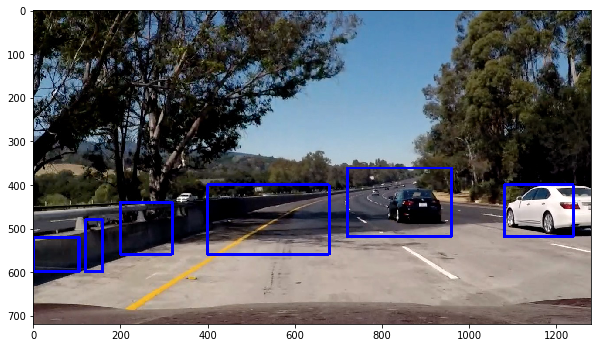

In [104]:
img = mpimg.imread('./test_images/test5.jpg')
img = pipeline(img)
plt.imshow(img)
plt.show()

In [ ]:
challenge_output = 'challenge_vid.mp4'

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)

clip1 = VideoFileClip('./challenge_video.mp4')
challenge_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

video = CompositeVideoClip([challenge_clip])
%time video.write_videofile(challenge_output, audio=False)

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')
img = crop_image(img)
small_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.8, overlap=0.5)
med_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.6, overlap=0.6)
large_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.4)
boxes = np.concatenate((small_boxes, med_boxes, large_boxes))
new_img = np.copy(img)
for bounding_box in boxes:
    cv2.rectangle(img, (bounding_box[2], bounding_box[0]),
                       (bounding_box[3], bounding_box[1]),
                       (255, 0, 0), 6)

plt.imshow(img)
plt.show()
my_heat = add_heat(img, boxes)
my_heat = apply_threshold(my_heat, 2)
labels = label_cars(my_heat, display=True)
draw_labeled_boxes(new_img, labels, display=True)

In [4]:
#------------------80-chars----------------------------------------------------|
def load_images(file_folder, file_format):
    """
    Returns an array of all images in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([mpimg.imread(file) for file in image_files])

In [94]:
def split_image(img, y_split):
    """
    Splits image in half top-bottom
    
    :param img: Image to split in half
    :param y_split: Decimal fraction to split image in half
    :return top: Top half of image
    :return bottom: Bottom half of image
    """
    height = img.shape[0]
    split_point = np.int(height*y_split)
    top = img[0:split_point]
    bottom = img[split_point:height-1]
    return top, bottom

In [11]:
#------------------80-chars----------------------------------------------------|
def crop_image(img, x_usable=(0.0,1.0), y_usable=(0.5,1.0)):
    """
    Crop parts of the image where cars should not exist
    
    :param img: Image to be cropped
    :param x_usable: Tuple - Fraction of image 0-1 in x start-end that's usable
    :param y_usable: Tuple - Fraction of image 0-1 in y start-end that's usable
    """
    x_start = np.int(img.shape[1]*x_usable[0])
    x_end   = np.int(img.shape[1]*x_usable[1])
    y_start = np.int(img.shape[0]*y_usable[0])
    y_end   = np.int(img.shape[0]*y_usable[1])
    return img[y_start:y_end,x_start:x_end,:]